In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [289]:
first_post = pd.read_json('data/politicos/json/mixed.json')
first_post.set_index('author', inplace=True)
first_post['multi_post'] = first_post['total_posts']>1
first_post.rename(columns={'first_post_body':'body'}, inplace=True)
first_post.drop([
         u'first_post_avg_response_ups', u'first_post_avg_response_downs',
                 u'first_post_datetime',              u'first_post_downs',
                       u'first_post_id',            u'first_post_link_id',
           u'first_post_response_downs',       u'first_post_response_ups',
                u'first_post_responses',    u'first_post_total_responses',
                      u'first_post_ups',            u'last_post_datetime',
                         u'parent_type',                u'post_datetimes',
                            u'post_ids',                   u'total_posts'],
               axis=1, inplace=True)
first_post.head()

,body,multi_post
author,,
netdroid9,Yes and no. Cosmetic procedures can be done fo...,True
grimsley33,I agree completely. These organizations need t...,True
bluedice,This just in: politicians do the immoral thing.,True
Cody2,Balls' got man?,True
firebat87,Went to High School in Florida. We had a Chine...,True


In [290]:
# Stem
stemmer = SnowballStemmer('english', ignore_stopwords=True)
first_post['body'] = first_post['body'].apply(lambda body: ' '.join(stemmer.stem(word) for word in body.split()))

In [291]:
# Count words
vectorizer = CountVectorizer(stop_words='english', max_features=3000)
#to try: ngram_range
doc_term_matrix = vectorizer.fit_transform(first_post['body'].values)

In [292]:
# Normalize counts to rates, bc comment lengths are different
dtm = doc_term_matrix.todense()
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)
# Rate per 1000 words is good for book writing, but to look at topics in short comments, need another metric. Consider TF-IDF.

In [293]:
# Normalization alternative: word rate is 1 or 0 per doc
rates = np.array(dtm>0).astype('int')

In [294]:
# to try: remove completely distinctive words
# https://de.dariah.eu/tatom/feature_selection.html

In [301]:
single_rates = rates[np.array(first_post['multi_post']==False)]
multi_rates = rates[np.array(first_post['multi_post']==True)]

In [302]:
single_avg_rate = np.mean(single_rates, axis=0)
np.unique(single_avg_rate.flat)

array([ 0.        ,  0.00352113,  0.00704225,  0.01056338,  0.01408451,
        0.01760563,  0.02112676,  0.02464789,  0.02816901,  0.03169014,
        0.03521127,  0.03873239,  0.04225352,  0.04577465,  0.04929577,
        0.0528169 ,  0.05985915,  0.07042254,  0.07394366,  0.08098592,
        0.08802817,  0.0915493 ,  0.09507042,  0.09859155,  0.10915493,
        0.11619718])

(array([  2.77000000e+03,   1.36000000e+02,   5.00000000e+01,
          2.70000000e+01,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          2.00000000e+00]),
 array([ 0.        ,  0.01161972,  0.02323944,  0.03485915,  0.04647887,
         0.05809859,  0.06971831,  0.08133803,  0.09295775,  0.10457746,
         0.11619718]),
 <a list of 10 Patch objects>)

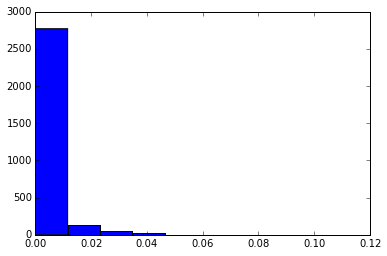

In [303]:
plt.hist(single_avg_rate.flat)

In [304]:
multi_avg_rate = np.mean(multi_rates, axis=0)
np.unique(multi_avg_rate.flat)

array([ 0.        ,  0.00206612,  0.00413223,  0.00619835,  0.00826446,
        0.01033058,  0.01239669,  0.01446281,  0.01652893,  0.01859504,
        0.02066116,  0.02272727,  0.02479339,  0.0268595 ,  0.02892562,
        0.03099174,  0.03305785,  0.03512397,  0.03719008,  0.0392562 ,
        0.04132231,  0.04338843,  0.04545455,  0.04752066,  0.04958678,
        0.05165289,  0.05371901,  0.05785124,  0.06198347,  0.06404959,
        0.07024793,  0.07231405,  0.07644628,  0.0785124 ,  0.1053719 ,
        0.10743802,  0.1177686 ,  0.12603306,  0.12809917,  0.1322314 ])

In [310]:
freq_words_single = np.array(vectorizer.get_feature_names())[np.argsort(-1*single_avg_rate)[:30]]
pd.Series(freq_words_single.flat)

0       like
1       just
2        don
3      think
4      peopl
5       fuck
6        say
7       http
8       make
9        com
10      know
11      time
12     right
13       way
14     thing
15      year
16      want
17      stop
18     state
19      live
20     world
21       tri
22       guy
23    realli
24      come
25      look
26       law
27      work
28     point
29      read
dtype: object

In [312]:
freq_words_multi = np.array(vectorizer.get_feature_names())[np.argsort(-1*multi_avg_rate)[:30]]
pd.Series(freq_words_multi.flat)

0        like
1        just
2       peopl
3         don
4       think
5        make
6        want
7      realli
8        know
9        http
10      thing
11      right
12       vote
13       time
14      obama
15        say
16      state
17        way
18        use
19       good
20       fuck
21        com
22        did
23        www
24     someon
25       read
26       year
27      money
28    support
29        tax
dtype: object

In [314]:
# Distinct words of multi_posters (difference in avg rate)
distinct_multi = multi_avg_rate - single_avg_rate
distinct_words_multi = np.array(vectorizer.get_feature_names())[np.argsort(-1*distinct_multi)[:30]]
pd.Series(distinct_words_multi.flat)

0          obama
1           vote
2         realli
3           make
4          peopl
5           help
6        support
7          parti
8           want
9           cost
10          idea
11           tax
12          mean
13       current
14       countri
15          good
16           did
17          base
18          fact
19         money
20        public
21         class
22         polit
23           www
24    republican
25         thing
26           low
27          hold
28           don
29          just
dtype: object

Multi-posters are more liberal? (need liberal/conservative detector). See Indico API to test hypothesis

In [319]:
# Distinct words of single_posters (difference in avg rate)
distinct_single = single_avg_rate - multi_avg_rate
distinct_words_single = np.array(vectorizer.get_feature_names())[np.argsort(-1*distinct_single)[:30]]
pd.Series(distinct_words_single)

0         fuck
1         stop
2          say
3          amp
4        world
5         home
6         life
7         real
8     internet
9          com
10       media
11        turn
12       haven
13          oh
14       video
15         saw
16     complet
17         big
18        mind
19         hey
20        live
21        news
22        post
23        yeah
24       topic
25      recent
26       gonna
27       story
28       simpl
29      whatev
dtype: object

Single posters complain? (try negative sentiment detector)

People who talk about marijuana and prison overcrowding post more than people who post about breast reconstructive surgery? Sympathy for victimless drug crimes that overcrowd prisons?

In [ ]:
print 'marijuana', vectorizer.get_feature_names().index('marijuana')

In [ ]:
multi_avg_rate[0,1108] - single_avg_rate[0,1108]

In [ ]:
np.sum(rates[:,1108]!=0)

In [ ]:
mj_indicies = np.argsort(np.array(rates[:,1108]!=0).flatten())[-4:] #talks about marijuana 
mj_posts = first_post.iloc[mj_indicies]
mj_posts

In [ ]:
for post in mj_posts['body']:
    print post
    print

"legal marijuana, and a slew of other "problems" that are only issu because of whini old peopl that will not accept change."
Reddit Politics is young liberal/libertarian audience? 

In [ ]:
from sklearn.feature_selection import chi2

In [327]:
word_rates_single_vs_multi = np.vstack([single_avg_rate, multi_avg_rate])
word_rates_single_vs_multi.shape

(2, 3000)

In [330]:
distinct_score, _ = chi2(rates, first_post['multi_post'])
distinct_score.shape

(3000,)

In [335]:
# Most distinct by chi2 (alternative to comparing averages)
pd.Series(np.array(vectorizer.get_feature_names())[np.argsort(-1*distinct_score)[:30]])

0         cost
1          amp
2        parti
3          saw
4         help
5         idea
6        class
7         home
8        obama
9         stop
10     current
11         bag
12          23
13        hang
14        oper
15        peac
16       weird
17     section
18    westboro
19       initi
20       innoc
21       catch
22        html
23        cabl
24     baptist
25       appar
26      public
27        unit
28     support
29         low
dtype: object

## Most popular words overall

In [337]:
# Most popular words overall
pd.Series(np.array(vectorizer.get_feature_names())[np.array(np.argsort(-1*np.mean(rates, axis=0)))[:30]])

0       like
1       just
2      peopl
3        don
4      think
5       make
6       http
7       know
8        say
9       fuck
10      want
11     right
12      time
13     thing
14    realli
15       com
16       way
17      vote
18     state
19      year
20     obama
21       use
22      good
23    someon
24      read
25       did
26       www
27      does
28     money
29      need
dtype: object

In [338]:
print 'fuck', vectorizer.get_feature_names().index('fuck')

fuck 763


In [339]:
np.sum(rates[:,763]!=0)

52

In [340]:
indicies = np.argsort(np.array(rates[:,763]!=0).flatten())[-52:]
indicies

array([372, 212,  11, 351, 741, 551, 404, 176, 395, 175, 577, 733, 568,
       397, 358, 116, 590, 442, 246, 453, 256, 296, 135, 317, 134, 128,
       559, 280, 488, 109, 269, 292, 236,  65, 521, 409, 411, 413, 336,
       167, 332, 598, 422,  52, 525,  55, 324, 322,  61, 234, 535, 426])

In [341]:
first_post['body'].iloc[11]

u"fuck school system and their administr sensitivity. i don't understand why expel a student for that is justified. good thing nasa gave her a full scholarship because that high school could have potenti ruin her life."

In [342]:
print 'vote', vectorizer.get_feature_names().index('vote')

vote 2799


In [343]:
np.sum(rates[:,2799]!=0)

44

In [344]:
indicies = np.argsort(np.array(rates[:,2799]!=0).flatten())[-52:]
indicies

array([254, 253, 252, 200, 247, 248, 201, 249, 754, 184,  26, 547, 182,
       394, 388, 565,  16, 368, 356, 191, 177, 274, 231,  36, 653, 664,
       461, 290, 292, 251, 298, 627, 138, 689, 140, 440, 213, 616, 701,
       516, 232,  56, 522, 602, 714, 336, 591,  40, 409, 339, 437, 560])

In [345]:
pd.DataFrame(first_post['body'].iloc[indicies])

,body
author,
haeSFA,biden seem much more commanding. probabl not a...
trollcaptured,yay for technocrats.
upsidedowntyger,candi crowley need to be firmer and tell them ...
juniuslb,perhap the reason why the american govern is u...
wowthrowaway,"knew i'd end up miss one, but that not my name."
PersonalOwn4g3,because.....reasons!!
t0mmy9,"i'm not from america, but fox still manag to r..."
SecretlyAGrizzly,for the full video: http://www.youtube.com/wat...
naked_short,i think the one thing keep me from vote for ob...


In [346]:
# See if there are any popular bigrams (and tri-grams with adjustment)
bigram_vectorizer = CountVectorizer(stop_words='english', max_features=3000, ngram_range=(1,2))
bigram_dtm = bigram_vectorizer.fit_transform(first_post['body'].values)

In [347]:
avg_counts = bigram_dtm.mean(axis=0)
avg_counts

matrix([[ 0.0234375 ,  0.00651042,  0.00651042, ...,  0.01041667,
          0.01041667,  0.00260417]])

In [348]:
pd.Series(np.array(bigram_vectorizer.get_feature_names())[np.argsort(-1*avg_counts)[0,:30]].flatten())

0      peopl
1       like
2       just
3        don
4      think
5       make
6       know
7       want
8       http
9       fuck
10    realli
11      vote
12       say
13      time
14     state
15     thing
16     right
17       com
18       way
19        gt
20       pay
21       tax
22     obama
23      year
24       use
25     money
26       www
27       tri
28    someon
29      read
dtype: object